# Solumetric: *main*

In [13]:
import deepchem as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch

import sys
import logging
logger = logging.getLogger()
logger.addHandler(logging.StreamHandler(stream=sys.stdout))
logger.info("test")

import warnings
warnings.filterwarnings("once")

In [14]:
# specify featurizer, splitter, and transformers

FEATURIZER = dc.feat.MolGraphConvFeaturizer(use_edges=True)
# FEATURIZER = dc.feat.MolGraphConvFeaturizer(use_edges=True, use_chirality=True, use_partial_charge=True)
# FEATURIZER = dc.feat.CircularFingerprint(radius=4, size=2048, chiral=True, bonds=True)

# SPLITTER = dc.splits.RandomSplitter()
SPLITTER = dc.splits.RandomStratifiedSplitter()

TRANSFORMERS = ["normalization"]

# load in Delaney dataset
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer=FEATURIZER, 
                                                       splitter=SPLITTER,
                                                       transformers=TRANSFORMERS,
                                                       reload=True,
                                                       data_dir="data",
                                                       save_dir="data",
                                                       seed=42,
                                                       log_every_n=1,
                                                       frac_train=0.8,
                                                       frac_valid=0.1,
                                                       frac_test=0.1)
train_dataset, valid_dataset, test_dataset = datasets

In [23]:
# replicate but with AqSolDB dataset
import os

from deepchem.molnet.load_function.molnet_loader import _MolnetLoader, TransformerGenerator
from deepchem.data import Dataset
from typing import List, Optional, Tuple, Union


class _AqSolDBLoader(_MolnetLoader):
    def create_dataset(self) -> Dataset:
        dataset_file = os.path.join(self.data_dir, "aqsoldb.csv")
        loader = dc.data.CSVLoader(tasks=self.tasks,
                                   feature_field="SMILES",
                                   featurizer=self.featurizer)
        return loader.create_dataset(dataset_file, shard_size=8192)


AQSOL_TASKS = ["Solubility"]

def load_aqsoldb(
    featurizer: Union[dc.feat.Featurizer, str] = 'ECFP',
    splitter: Union[dc.splits.Splitter, str, None] = 'scaffold',
    transformers: List[Union[TransformerGenerator, str]] = ["normalization"],
    reload: bool = True,
    data_dir: Optional[str] = None,
    save_dir: Optional[str] = None,
    **kwargs
) -> Tuple[List[str], Tuple[Dataset, ...], List[dc.trans.Transformer]]:
    loader = _AqSolDBLoader(featurizer,
                            splitter,
                            transformers,
                            AQSOL_TASKS, 
                            data_dir,
                            save_dir,
                            **kwargs)
    return loader.load_dataset('aqsoldb', reload)

In [24]:
tasks, datasets, transformers = load_aqsoldb(featurizer=FEATURIZER, 
                                             splitter=SPLITTER,
                                             transformers=TRANSFORMERS,
                                             reload=True,
                                             data_dir="data",
                                             save_dir="data",
                                             seed=42,
                                             log_every_n=1,
                                             frac_train=0.8,
                                             frac_valid=0.1,
                                             frac_test=0.1)
train_dataset, valid_dataset, test_dataset = datasets

In [25]:
train_dataset.X.shape, valid_dataset.X.shape, test_dataset.X.shape

((7865,), (983,), (983,))

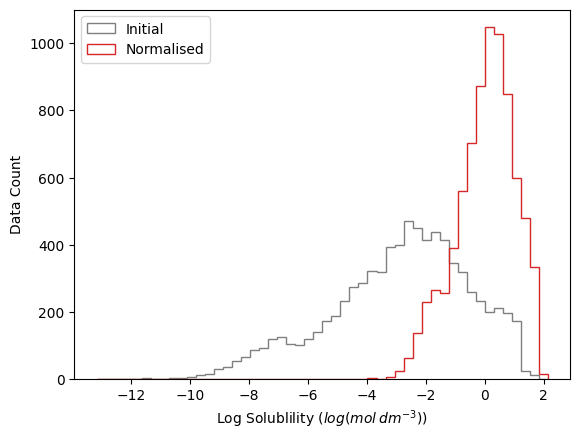

In [26]:
# ensure y is normalised
_, bins, _ = plt.hist(transformers[0].untransform(train_dataset.y),
                      bins=50,
                      histtype="step",
                      label="Initial",
                      density=False,
                      color="tab:gray");
plt.hist(train_dataset.y,
         bins=bins,
         histtype="step",
         label="Normalised",
         density=False,
         color="tab:red");
plt.xlabel(r"Log Solublility $(log(mol\:dm^{-3}))$")
plt.ylabel("Data Count")
plt.legend()
plt.savefig("assets/target_normalised.svg")
np.testing.assert_allclose((train_dataset.y.mean(), train_dataset.y.std()),
                           (0.0, 1.0),
                           atol=1e-7)

In [27]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [28]:
METRICS = [dc.metrics.Metric(dc.metrics.rms_score),
           dc.metrics.Metric(dc.metrics.mean_absolute_error),
           dc.metrics.Metric(dc.metrics.r2_score),]

SPLIT_TO_DATASET = dict(train=train_dataset,
                        valid=valid_dataset,
                        test=test_dataset)

In [29]:
# BATCH_SIZES = [4, 8, 16, 32, 64]
BATCH_SIZE = 64
MAX_EPOCHS = 512
REPLICATES = 1
PATIENCE = 64
# NODE_OUT_FEATS = [16, 32, 64, 96, 128]
# EDGE_HIDDEN_FEATS = [32, 64, 128, 192, 256]
# NUM_STEP_MESSAGE_PASSING = [3, 4, 5, 6, 7]

In [37]:
# convenience function to initialise new model
def get_model():
    LOSS = dc.models.losses.L2Loss()
    OPTIMIZER = dc.models.optimizers.Adam(learning_rate=1e-3,
                                          beta1=0.9,
                                          beta2=0.999,
                                          epsilon=1e-8,
                                          weight_decay=0)
    model = dc.models.torch_models.MPNNModel(n_tasks=1,
                                             mode='regression', 
                                             node_out_feats=64,
                                             edge_hidden_feats=128,
                                             num_step_message_passing=5,
                                             num_step_set2set=8,
                                             num_layer_set2set=4,
                                             number_atom_features=30,
                                             number_bond_features=11,
                                             batch_size=BATCH_SIZE,
                                             device="cuda",
                                             optimizer=OPTIMIZER,
                                             seed=42,
                                             log_frequency=1,
                                             model_dir="model",)
    """
    xgboost_model = xgboost.XGBRegressor(n_estimators=100,
                                         objective="reg:squarederror",
                                         random_state=42,
                                         device="cpu",)
    model = dc.models.gbdt_models.GBDTModel(xgboost_model,
                                            model_dir="model_xgboost",)
    """
                                            
                                 
    return model

# convenience function to initialise early stopper
def get_early_stopper():
    early_stopper = EarlyStopper(patience=PATIENCE,
                                 min_delta=0)
    return early_stopper

In [40]:
from IPython.display import clear_output

def run_benchmarking():

    # final outputs from benchmarking
    outputs = dict(train_losses=[], train_errors=[], valid_errors=[], metrics=[], models=[])
    # iterate over replicates
    for replicate in range(REPLICATES):
        # initialise new model and early stopper
        model = get_model()
        early_stopper = get_early_stopper()
        # per-replicate logging
        train_losses = []
        train_errors = []
        valid_errors = []
        # log
        print(f"Run {replicate+1:2d}/{REPLICATES:2d}")
        # iterate over epochs
        for epoch in range(MAX_EPOCHS):
            # train 1 epoch
            batch_generator = model.default_generator(train_dataset,
                                                      epochs=1,
                                                      mode="fit",
                                                      deterministic=False,
                                                      pad_batches=False)
            loss = model.fit_generator(batch_generator, all_losses=train_losses,) # appends losses to train_losses
            # track stats
            train_mse = model.evaluate(train_dataset, METRICS, transformers)["rms_score"]
            valid_mse = model.evaluate(valid_dataset, METRICS, transformers)["rms_score"]
            # check for early stop criterion
            if early_stopper.early_stop(valid_mse):
                break
            # log errors
            if epoch == 0:
                print(f"Epoch {epoch+1:3d} | {valid_mse:.4f} | {early_stopper.counter:2d}")
            else:
                print(f"Epoch {epoch+1:3d} | {valid_errors[-1]:.4f} --> {valid_mse:.4f} | {early_stopper.counter:2d}")
            train_errors.append(train_mse)
            valid_errors.append(valid_mse)
            # plot learning curve
            if epoch % 10 == 0:
                plt.plot(train_errors, label="train")
                plt.plot(valid_errors, label="valid")
                plt.legend()
                plt.show()
        # add losses/errors to final output
        outputs["train_losses"].append(train_losses)
        outputs["train_errors"].append(train_errors)
        outputs["valid_errors"].append(valid_errors)

        metrics = {}
        for split in "train", "valid", "test":
            dataset = SPLIT_TO_DATASET[split]
            metrics[split] = model.evaluate(dataset, METRICS, transformers)
        outputs["metrics"].append(metrics)

        # save model
        outputs["models"].append(model)
        
        # clear iPython output
        clear_output(wait=True)
        
    return outputs

outputs = run_benchmarking()
outputs

{'train_losses': [[0.9063844680786133,
   1.2931591272354126,
   0.9662516713142395,
   0.7868711352348328,
   0.8781397342681885,
   0.7588483691215515,
   0.724527895450592,
   1.0912740230560303,
   0.850827693939209,
   0.8561819791793823,
   0.4946447014808655,
   0.980474591255188,
   0.8947979211807251,
   0.6195698976516724,
   0.905895471572876,
   0.7792305946350098,
   0.9957006573677063,
   0.6563876867294312,
   0.8195627331733704,
   0.7449033856391907,
   1.0052011013031006,
   0.6090790033340454,
   1.0002315044403076,
   0.9037827849388123,
   0.8869336843490601,
   0.6255064606666565,
   0.7773830890655518,
   0.8031995892524719,
   0.5253826379776001,
   0.8251553177833557,
   0.7247631549835205,
   0.85350501537323,
   0.5937615036964417,
   0.6192353367805481,
   0.8897209167480469,
   0.7194243669509888,
   0.9351817965507507,
   0.7011154890060425,
   0.8195574283599854,
   0.5262024402618408,
   0.7528446912765503,
   0.7939639091491699,
   0.8815058469772339,
 

In [42]:
import json

OUT_FILE = "MPNN_DATA_AUGMENTED"

with open(f"results/{OUT_FILE}.json", "w") as fout:
    json.dump(outputs,
              fout,
              indent=4,
              default=lambda x: x.get_global_step(),)

In [43]:
for replicate in range(REPLICATES):
    print(f"Total training batches {replicate}: {outputs['models'][replicate]}")

Total training batches 0: <deepchem.models.torch_models.mpnn.MPNNModel object at 0x73f28558d590>


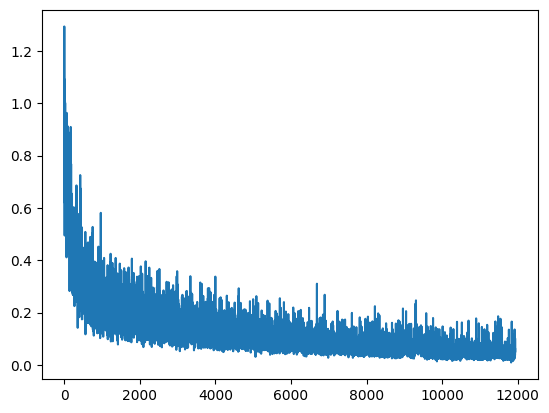

In [44]:
for replicate in range(REPLICATES):
    plt.plot(outputs["train_losses"][replicate])

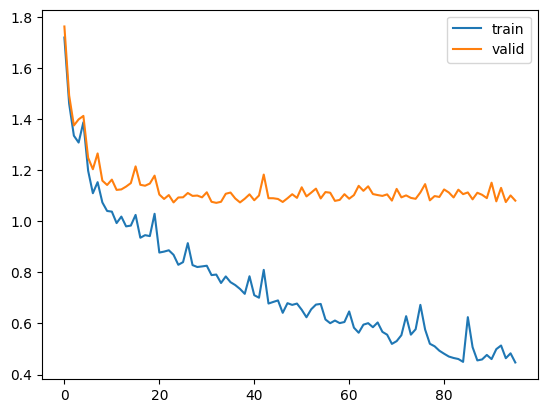

In [47]:
plt.plot(outputs["train_errors"][replicate], label="train")
plt.plot(outputs["valid_errors"][replicate], label="valid")
plt.legend()

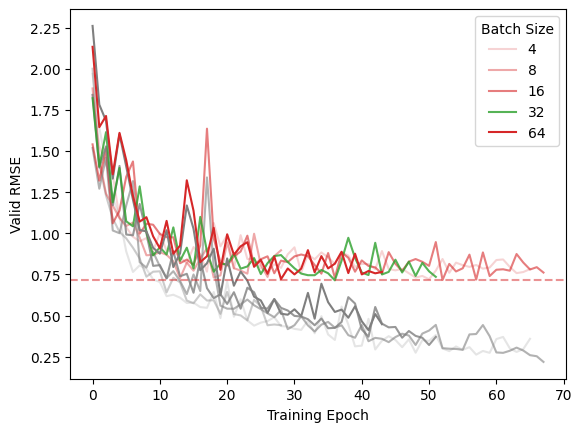

In [142]:
def plot_batch_sizes():
    
    IN_FILE = "MPNN_batch_sizes_4_8_16_32_64"
    
    with open(f"results/{IN_FILE}.json", "r") as fin:
        outputs = json.load(fin,)
        
    min_replicate, min_valid_error = min(enumerate([min(outputs["valid_errors"][i]) for i in range(REPLICATES)]),
                                         key=lambda x: x[1])
    for i in range(REPLICATES):
        train_errors = outputs["train_errors"][i]
        valid_errors = outputs["valid_errors"][i]
        plt.plot(train_errors, c="tab:gray", alpha=0.2*(i+1))
        if i == min_replicate:
            plt.plot(valid_errors, label=BATCH_SIZES[i], c="tab:green", alpha=0.2*(i+1))
        else:
            plt.plot(valid_errors, label=BATCH_SIZES[i], c="tab:red", alpha=0.2*(i+1))
    plt.xlabel("Training Epoch")
    plt.ylabel("Valid RMSE")
    plt.axhline(y=min_valid_error, c="tab:red", alpha=0.5, ls="--")
    plt.legend(title="Batch Size")
    plt.savefig("assets/batch_size.svg")
    
plot_batch_sizes()

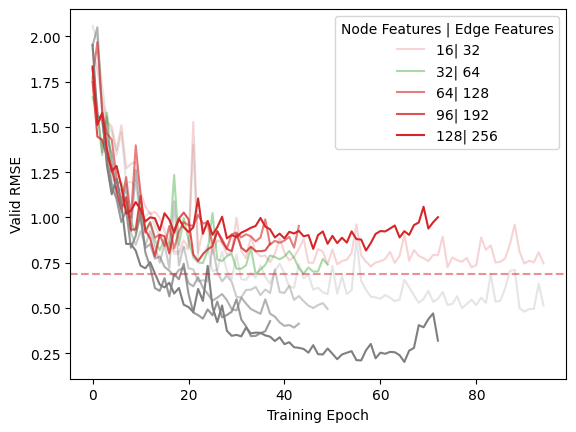

In [143]:
def plot_node_out_feats():
    
    IN_FILE = "MPNN_node_out_feats_16_32_64_96_128_edge_hidden_feats_2x"
    
    with open(f"results/{IN_FILE}.json", "r") as fin:
        outputs = json.load(fin,)
        
    min_replicate, min_valid_error = min(enumerate([min(outputs["valid_errors"][i]) for i in range(REPLICATES)]),
                                         key=lambda x: x[1])
    for i in range(REPLICATES):
        train_errors = outputs["train_errors"][i]
        valid_errors = outputs["valid_errors"][i]
        plt.plot(train_errors, c="tab:gray", alpha=0.2*(i+1))
        if i == min_replicate:
            plt.plot(valid_errors, label=f"{NODE_OUT_FEATS[i]}| {EDGE_HIDDEN_FEATS[i]}", c="tab:green", alpha=0.2*(i+1))
        else:
            plt.plot(valid_errors, label=f"{NODE_OUT_FEATS[i]}| {EDGE_HIDDEN_FEATS[i]}", c="tab:red", alpha=0.2*(i+1))
    
    plt.xlabel("Training Epoch")
    plt.ylabel("Valid RMSE")
    plt.axhline(y=min_valid_error, c="tab:red", alpha=0.5, ls="--")
    plt.legend(title="Node Features | Edge Features")
    plt.savefig("assets/node_out_feats.svg")
    
plot_node_out_feats()

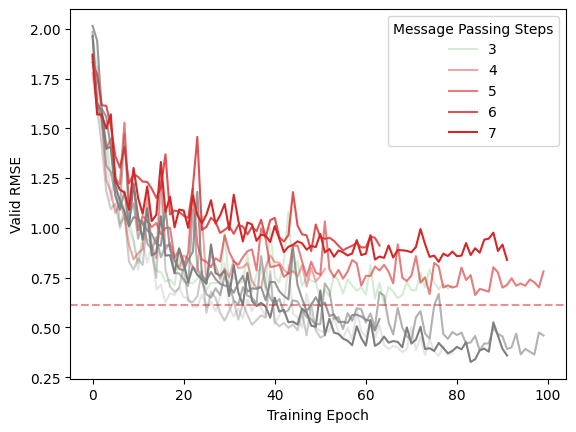

In [148]:
def plot_message_passing_steps():
    
    IN_FILE = "MPNN_num_step_message_passings_3_4_5_6_7"
    
    with open(f"results/{IN_FILE}.json", "r") as fin:
        outputs = json.load(fin,)
        
    min_replicate, min_valid_error = min(enumerate([min(outputs["valid_errors"][i]) for i in range(REPLICATES)]),
                                         key=lambda x: x[1])
    for i in range(REPLICATES):
        train_errors = outputs["train_errors"][i]
        valid_errors = outputs["valid_errors"][i]
        plt.plot(train_errors, c="tab:gray", alpha=0.2*(i+1))
        if i == min_replicate:
            plt.plot(valid_errors, label=NUM_STEP_MESSAGE_PASSINGS[i], c="tab:green", alpha=0.2*(i+1))
        else:
            plt.plot(valid_errors, label=NUM_STEP_MESSAGE_PASSINGS[i], c="tab:red", alpha=0.2*(i+1))
    
    plt.xlabel("Training Epoch")
    plt.ylabel("Valid RMSE")
    plt.axhline(y=min_valid_error, c="tab:red", alpha=0.5, ls="--")
    plt.legend(title="Message Passing Steps")
    plt.savefig("assets/message_passing_steps.svg")
    
plot_message_passing_steps()

In [48]:
SPLITS = SPLIT_TO_DATASET.keys()

def combine_errors(outputs):
    metrics = outputs["metrics"]
    metric_names = list(metrics[0].values())[0].keys()
    errors = {split: {metric: [] for metric in metric_names} for split in SPLITS}
    for split in "train", "valid", "test":
        for metric in metric_names:
            for i in range(REPLICATES):
                errors[split][metric].append(metrics[i][split][metric])
    return errors

def display_error_stats(errors):
    for split in SPLITS:
        print(f"{split}")
        print("-----")
        for metric, values in errors[split].items():
            values = np.array(values, dtype=np.float64)
            print(f"{metric:20}: {values.mean().item():.4f} +- {values.std().item():.4f}")
        print("-----")

errors = combine_errors(outputs)
display_error_stats(errors)

train
-----
rms_score           : 0.6060 +- 0.0000
mean_absolute_error : 0.4324 +- 0.0000
r2_score            : 0.9337 +- 0.0000
-----
valid
-----
rms_score           : 1.1208 +- 0.0000
mean_absolute_error : 0.7664 +- 0.0000
r2_score            : 0.7756 +- 0.0000
-----
test
-----
rms_score           : 1.0260 +- 0.0000
mean_absolute_error : 0.7155 +- 0.0000
r2_score            : 0.8052 +- 0.0000
-----


## Benchmarking

### GBRTs (XGBoost)

In [55]:
import json

IN_FILE = "MPNN_DEFAULT"

with open(f"results/{IN_FILE}.json", "r") as fin:
    outputs = json.load(fin,)

errors = combine_errors(outputs)
display_error_stats(errors)

train
-----
rms_score           : 0.3734 +- 0.0406
mean_absolute_error : 0.2785 +- 0.0324
r2_score            : 0.9679 +- 0.0068
-----
valid
-----
rms_score           : 0.7857 +- 0.0496
mean_absolute_error : 0.5677 +- 0.0292
r2_score            : 0.8430 +- 0.0204
-----
test
-----
rms_score           : 0.7776 +- 0.0263
mean_absolute_error : 0.5770 +- 0.0167
r2_score            : 0.8736 +- 0.0085
-----


### MPNN Model

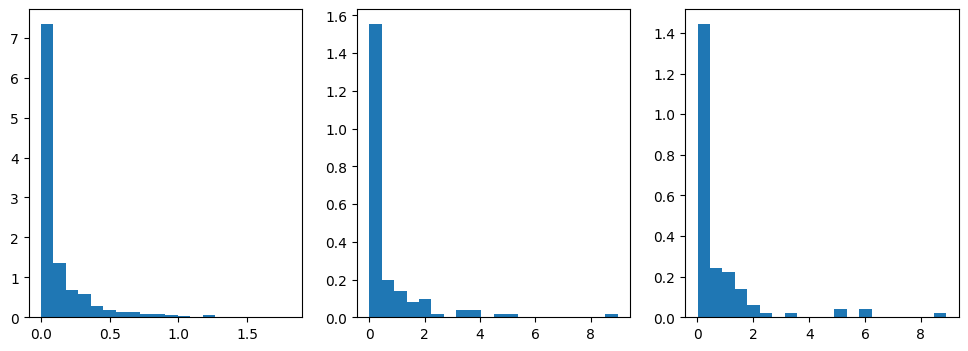

In [245]:
fig = plt.figure(figsize=(12, 4))
axs = fig.subplots(1, 3)

for i, split in enumerate(("train", "valid", "test")):
    dataset = split_to_dataset[split]
    y_true = transformers[0].untransform(dataset.y)
    y_pred = transformers[0].untransform(model.predict_on_batch(dataset.X))
    squared_errors = (y_true - y_pred)**2
    axs[i].hist(squared_errors, bins=20, density=True)

In [231]:
y_pred = model.predict_on_batch(test_dataset.X[:16])
for molecule, y_true, y_pred in zip(test_dataset.ids, test_dataset.y, y_pred):
    log_sol_true = transformers[0].untransform(y_true).item()
    log_sol_pred = transformers[0].untransform(y_pred).item()
    sol_true = np.exp(log_sol_true)
    sol_pred = np.exp(log_sol_pred)
    print(f"{molecule:60}: {log_sol_true:.4f} ({sol_true:.4f}), {log_sol_pred:.4f} ({sol_pred:.4f})")

ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl              : -6.2900 (0.0019), -6.6737 (0.0013)
CCCCCCCC(=O)OC                                              : -3.1700 (0.0420), -2.8783 (0.0562)
CN(C)C(=O)SCCCCOc1ccccc1                                    : -3.9270 (0.0197), -2.6222 (0.0726)
CCCCCCCI                                                    : -4.8100 (0.0081), -5.3164 (0.0049)
CC(C)OC=O                                                   : -0.6300 (0.5326), -0.2456 (0.7822)
c1ccccc1n2ncc(N)c(Br)c2(=O)                                 : -3.1270 (0.0438), -0.7096 (0.4919)
Cc1ccc(C)c2ccccc12                                          : -4.1400 (0.0159), -4.5145 (0.0109)
Cc1cc2c3ccccc3ccc2c4ccccc14                                 : -6.5700 (0.0014), -7.9646 (0.0003)
CCC(Br)(CC)C(=O)NC(N)=O                                     : -2.6800 (0.0686), -1.6996 (0.1828)
O=C2CN(N=Cc1ccc(o1)N(=O)=O)C(=O)N2                          : -3.3800 (0.0340), -1.5253 (0.2176)
CC(C)C(C(=O)OC(C#N)c1cccc(Oc2c

In [28]:
import os
os.environ['DEEPCHEM_DATA_DIR'] = "/home/rmrr/career/uncountable/data"

featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
splitter = "random"
# splitter = dc.splits.MolecularWeightSplitter()
transformers = ["normalization"]

tasks, datasets, transformers = dc.molnet.load_qm9(featurizer=featurizer, 
                                                   splitter=splitter,
                                                   transformers=transformers,
                                                   reload=True,
                                                   data_dir="data",
                                                   save_dir="data")

train_dataset, valid_dataset, test_dataset = datasets

In [30]:
train_dataset.get_shape()

((105576,), (105576, 12), (105576, 12), (105576,))

In [32]:
import wandb
from deepchem.models import WandbLogger

os.environ["WANDB_API_KEY"] = "#####"
wandb_logger = WandbLogger(project="deepchem")

In [33]:
BATCH_SIZE=32
# wandb_logger.experiment.config["batch_size"] = BATCH_SIZE

In [34]:
model = dc.models.torch_models.MPNNModel(n_tasks=1,
                                         node_out_feats = 64,
                                         edge_hidden_feats = 128,
                                         num_step_message_passing = 3,
                                         num_step_set2set = 6,
                                         num_layer_set2set = 3,
                                         mode = 'regression',
                                         number_atom_features = 30,
                                         number_bond_features = 11,
                                         self_loop= False,
                                         batch_size=BATCH_SIZE,
                                         model_dir="model",
                                         # wandb=True,
                                         learning_rate=0.001, 
                                         device="cpu",
                                         wandb_logger=wandb_logger)

In [15]:
solubilities = model.predict_on_batch(test_dataset.X[:10])
for molecule, y_pred, y in zip(test_dataset.ids, solubilities, test_dataset.y):
    print(y_pred, y, molecule)

[-1.376157] [-1.60000553] c1cc2ccc3cccc4ccc(c1)c2c34
[0.52692] [0.20952792] Cc1cc(=O)[nH]c(=S)[nH]1
[-0.68075764] [-0.01497035] Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 
[-1.6134826] [-2.82071486] c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45
[-1.1654787] [-0.52783277] C1=Cc2cccc3cccc1c23
[1.6020465] [1.10268267] CC1CO1
[-0.6525793] [-0.88877179] CCN2c1ccccc1N(C)C(=S)c3cccnc23 
[-0.7522491] [-0.52541361] CC12CCC3C(CCc4cc(O)ccc34)C2CCC1=O
[-0.32961416] [-0.76249152] Cn2cc(c1ccccc1)c(=O)c(c2)c3cccc(c3)C(F)(F)F
[0.8767008] [-0.63911424] ClC(Cl)(Cl)C(NC=O)N1C=CN(C=C1)C(NC=O)C(Cl)(Cl)Cl 


In [63]:
from rdkit import Chem

aqsoldb_file = "data/aqsoldb.csv"
aqsoldb_df = pd.read_csv(aqsoldb_file,
                         # index_col="ID",
                         usecols=["ID", "Name", "SMILES", "Solubility"],)
aqsoldb_df.set_index("ID")

,Name,SMILES,Solubility
ID,,,
A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127
A-4,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
A-5,4-chlorobenzaldehyde,Clc1ccc(C=O)cc1,-2.177078
A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409
A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065
...,...,...,...
I-84,tetracaine,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000
I-85,tetracycline,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000
I-86,thymol,c1(cc(ccc1C(C)C)C)O,-2.190000


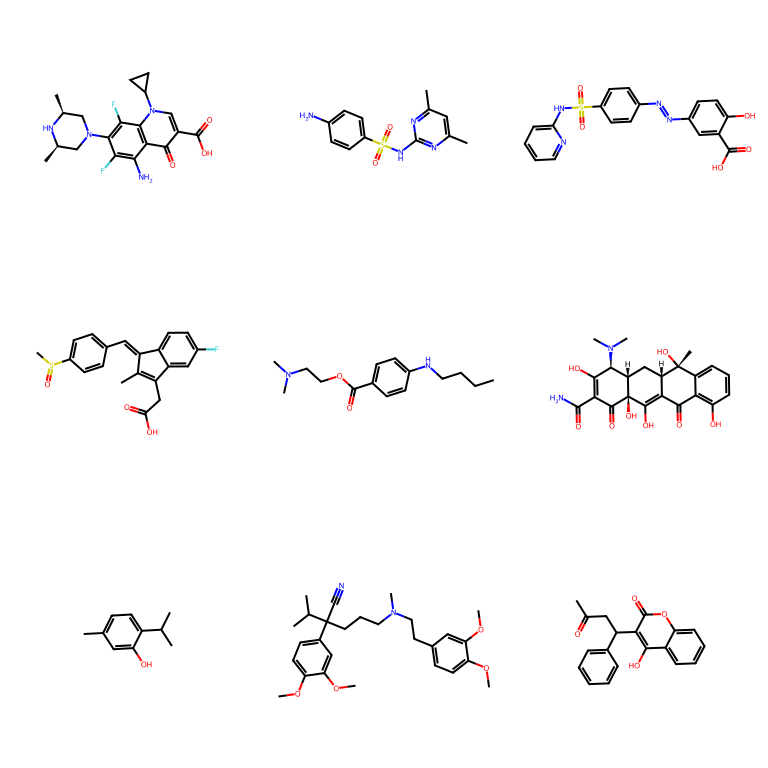

In [88]:
from IPython.display import display, SVG
def show_smiles(df):
    # Convert SMILES strings to molecular structures and display them in a grid
    mols = [Chem.MolFromSmiles(smile) for smile in df["SMILES"].to_list()[-9:]]
    img = Chem.Draw.MolsToGridImage(mols, 
                                    molsPerRow=3,
                                    subImgSize=(256, 256),
                                    # legends=[name for name in df["Name"].to_list()[:16]],
                                    useSVG=True,)
    return img

img = show_smiles(aqsoldb_df)

with open("assets/molecules.svg", "w") as fin:
    fin.write(img.data) # svg output is stored in `data` attribute
SVG(img.data)

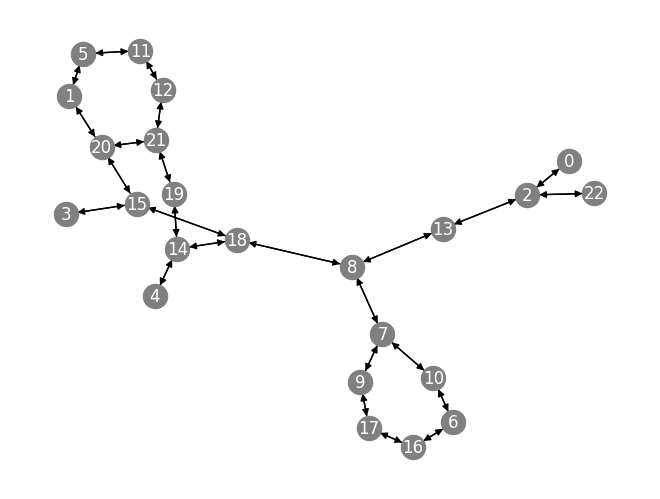

In [101]:
# show example graph network generated in MPNN model

import networkx as nx
from dgllife.utils import smiles_to_bigraph
from dgl import to_networkx

mol_graph = smiles_to_bigraph(aqsoldb_df["SMILES"].iloc[-1])
mol_graph = to_networkx(mol_graph)
nx.draw_spring(mol_graph,
               with_labels=True,
               node_color="#808080",
               font_color="white",)
plt.savefig("assets/graph.svg")